In [ ]:
import torch, torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import os, time, pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

# DataLoader

In [ ]:
class Mydataset(Dataset):
  def __init__(self, path_csv,path_x,path_xhat):
    self.csv = pd.read_csv(path_csv)
    self.path_x = path_x
    self.path_y = path_xhat

  def __len__(self):
    return len(self.csv['x'])

  def __getitem__(self,idx):
    csv_x = self.csv['x']
    csv_xhat = self.csv['xhat']
    csv_duration = self.csv['len']
    file_name_x = csv_x[idx][2:-4]
    file_name_xhat = csv_xhat[idx]

    x , sr_x = torchaudio.load(f'{self.path_x}/{file_name_x}')
    xhat, sr_xhat = torchaudio.load(f'{self.path_y}/{file_name_xhat}')

    required_pad_len = 30*sr_x - len(x[0])
    if csv_duration[idx] < 30.00:
       x = F.pad(x,(0,required_pad_len))
       xhat = F.pad(xhat,(0,required_pad_len))

    return x, xhat


In [ ]:
path_csv = '/content/drive/MyDrive/New_data_set/new_csv.csv'
path_x = '/content/drive/MyDrive/New_data_set/set_b'
path_xhat = '/content/drive/MyDrive/New_data_set/denoised'
dataset = Mydataset(path_csv,path_x,path_xhat)
trainset, test_set = random_split(dataset,[len(dataset)-30,30])
train_loader = DataLoader(trainset,12,shuffle=True,drop_last=True)
test_loader = DataLoader(test_set,12,shuffle=True,drop_last=True)

# NN

In [ ]:
class AE(nn.Module):
  def __init__(self,waveform=True):
    super(AE,self).__init__()
    self.waveform = waveform
    
    self.encoder = nn.Sequential(
        nn.Conv1d(1,10,20,3),
        nn.ReLU(),
        nn.Conv1d(10,15,20,3),
        nn.Tanh()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(15,10,20,3),
        nn.ReLU(),
        nn.ConvTranspose1d(10,1,27,3),
        nn.Tanh()
    )

  def forward(self, x):
    if self.waveform:
      compressed = self.encoder(x)
      decoded = self.decoder(compressed)
      return decoded
      

# Initillizing models

In [ ]:
#Model 1
ae_adam = AE().to(device)
epos = 200
learning_rate = 1e-3
loss_fn_adam = nn.MSELoss()
optimizer_adam = torch.optim.Adam(ae_adam.parameters(), lr=learning_rate,weight_decay=1e-5)

In [ ]:
#Model 2

ae_lazy_adam = AE().to(device)
#use default params
loss_fn_lazy_adam = nn.MSELoss()
optimizer_lazy_adam = torch.optim.SGD(ae_lazy_adam.parameters(),lr=0.01,momentum=0.9)
torch.backends.cudnn.benchmark = True

In [ ]:
def get_time(sr,len_data):
  duration = len_data/sr
  #dt = 1/sr
  time = np.arange(0,duration,1/sr)
  return time

In [ ]:
def save_audio_and_Img(x,output,xhat,epo,adam=True):
  dir = f'/content/drive/MyDrive/New_data_set/try200/Epoch:{epo}'
  if adam: os.mkdir(dir)

  #save as .wav
  if adam:
    torchaudio.save(f'{dir}/{epo}_x_adam.wav',x,4000)
    torchaudio.save(f'{dir}/{epo}_xhat_adam.wav',xhat,4000)
    torchaudio.save(f'{dir}/{epo}_xhat_generated_adam.wav',output,4000)
  else:
    torchaudio.save(f'{dir}/{epo}_x_SGD.wav',x,4000)
    torchaudio.save(f'{dir}/{epo}_xhat_SGD.wav',xhat,4000)
    torchaudio.save(f'{dir}/{epo}_xhat_generated_SGD.wav',output,4000)

  #save the plt as png
  fig, (ax1,ax2,ax3) = plt.subplots(3)
  fig.suptitle(f'Result after {epo} epocs')
  ax1.set_title('input x')
  ax2.set_title('noiseless x')
  ax3.set_title('output xhat')

  if adam:
    sr_x, data_x = wavfile.read(f'{dir}/{epo}_x_adam.wav')
    sr_xhat, data_xhat = wavfile.read(f'{dir}/{epo}_xhat_adam.wav')
    sr_op, data_op = wavfile.read(f'{dir}/{epo}_xhat_generated_adam.wav')
  else:
    sr_x, data_x = wavfile.read(f'{dir}/{epo}_x_SGD.wav')
    sr_xhat, data_xhat = wavfile.read(f'{dir}/{epo}_xhat_SGD.wav')
    sr_op, data_op = wavfile.read(f'{dir}/{epo}_xhat_generated_SGD.wav')


  ax1.plot(get_time(sr_x,len(data_x)),data_x)
  ax2.plot(get_time(sr_xhat,len(data_xhat)),data_xhat)
  ax3.plot(get_time(sr_op,len(data_op)),data_op)

  if adam : plt.savefig(f'{dir}/{epo}_fullplots_adam.png')
  else :plt.savefig(f'{dir}/{epo}_fullplots_SGD.png')
  plt.close(fig)
  print(f'Epoc : {epo}\tSaved audio and image')

In [ ]:
def cal_time(st,et):
  time_taken = et - st
  in_mins = int(time_taken/60)
  in_secs = int(time_taken - (in_mins*60))
  return in_mins,in_secs

# Training

In [ ]:
total_loss_adam = list()
#total_loss_lazy = list()
total_val_loss_adam = list()
#total_val_loss_lazy = list()
save_loss = float('inf')
for epo in range(epos):
  stt = time.time()
  ae_adam.train()
  #ae_lazy_adam.train()
  for _ , data in enumerate(train_loader):
    x, xhat = data
    x = x.to(device)
    xhat = xhat.to(device)

    output_adam = ae_adam.forward(x)
   # output_lazy_adam = ae_lazy_adam.forward(x)

    loss_adam = loss_fn_adam(output_adam,xhat)
    #loss_lazy = loss_fn_lazy_adam(output_lazy_adam,xhat)

    optimizer_adam.zero_grad()
    #optimizer_lazy_adam.zero_grad()
    loss_adam.backward()
    #loss_lazy.backward()
    optimizer_adam.step()
    #optimizer_lazy_adam.step()
    
    if save_loss > loss_adam.item():
      save_loss = loss_adam.item()
      print(f'Saved during {loss_adam.item()} epoc')
      torch.save(ae_adam,'/content/drive/MyDrive/New_data_set/200epoch_adam_iter.pt')


  ett = time.time()

  total_loss_adam.append(loss_adam.item())
  #total_loss_lazy.append(loss_lazy.item())
  
  mins, secs = cal_time(stt,ett)
  print(f'Epoch : {epo}\tTime taken : {mins} mins {secs} secs')
  print(f'\tTrain loss (using regular adam) : {loss_adam.item()}')
  #print(f'\tTrain loss (using SGD) : {loss_lazy.item()}')
  
  ae_adam.eval()
  #ae_lazy_adam.eval()
  with torch.no_grad():
    ste = time.time()
    for _ , data in enumerate(test_loader):
      x, xhat = data
      x = x.to(device)
      xhat = xhat.to(device)

      output_adam = ae_adam.forward(x)
      #output_lazy = ae_lazy_adam.forward(x)

      loss_adam = loss_fn_adam(output_adam,xhat)
      #loss_lazy = loss_fn_lazy_adam(output_lazy,xhat)

      loss_adam.detach()
      #loss_lazy.detach()

    ete = time.time()
    mins ,secs = cal_time(ste,ete)

    total_val_loss_adam.append(loss_adam.item())
    #total_val_loss_lazy.append(loss_lazy.item())

    print(f'\tTest time : {mins} mins {secs} secs')
    print(f'\tTest loss (Using adam) : {loss_adam.item()}')#\tTest loss (Using SGD) : {loss_lazy.item()}')

    save_audio_and_Img(x[0].to('cpu'),output_adam[0].to('cpu'),xhat[0].to('cpu'),epo,adam=True)
    #save_audio_and_Img(x[0].to('cpu'),output_lazy[0].to('cpu'),xhat[0].to('cpu'),epo,adam=False)

torch.save(ae_adam,'/content/drive/MyDrive/New_data_set/200epoch_adam.pt')
#torch.save(ae_lazy_adam,'/content/drive/MyDrive/New_data_set/lazy_adam_dual.pt')



Saved during 0.0009211805881932378 epoc
Saved during 0.0004999857628718019 epoc
Saved during 0.00044632828212343156 epoc
Saved during 0.00026202286244370043 epoc
Saved during 0.00017495028441771865 epoc
Epoch : 0	Time taken : 0 mins 56 secs
	Train loss (using regular adam) : 0.0002547271433286369
	Test time : 0 mins 10 secs
	Test loss (Using adam) : 0.0005434955819509923
Epoc : 0	Saved audio and image
Saved during 0.0001442467182641849 epoc
Saved during 0.000140298594487831 epoc
Epoch : 1	Time taken : 0 mins 2 secs
	Train loss (using regular adam) : 0.0002649630478117615
	Test time : 0 mins 2 secs
	Test loss (Using adam) : 0.00048160902224481106
Epoc : 1	Saved audio and image
Saved during 0.00012768086162395775 epoc
Saved during 8.003782568266615e-05 epoc
Epoch : 2	Time taken : 0 mins 1 secs
	Train loss (using regular adam) : 0.00029673127573914826
	Test time : 0 mins 0 secs
	Test loss (Using adam) : 0.00020352295541670173
Epoc : 2	Saved audio and image
Epoch : 3	Time taken : 0 mins 1 

<function matplotlib.pyplot.show>

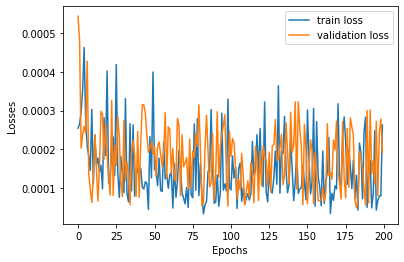

In [ ]:
plt.plot(total_loss_adam,label='train loss')
plt.plot(total_val_loss_adam,label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.savefig('losses.png')
plt.show

In [ ]:
with open('Train_loss_adam.pkl','wb') as f:
  pickle.dump(total_loss_adam,f,protocol=pickle.HIGHEST_PROTOCOL)
  f.close()
with open("Train_loss_sgd.pkl",'wb') as f:
  pickle.dump(total_loss_lazy,f,protocol=pickle.HIGHEST_PROTOCOL)
  f.close()
with open('Test_loss_adam.pkl','wb') as f:
  pickle.dump(total_val_loss_adam,f,protocol=pickle.HIGHEST_PROTOCOL)
  f.close()
with open("Test_loss_sgd.pkl",'wb') as f:
  pickle.dump(total_val_loss_lazy,f,protocol=pickle.HIGHEST_PROTOCOL)
  f.close()

# Inference

In [ ]:
def getSize(model):
  param_size, buffer_size = 0,0
  for parameter in model.parameters():
    param_size+= parameter.nelement() * parameter.element_size()
  for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
  size = (param_size+buffer_size)/1024**2
  #round it out to required decimal places.
  if size <1 :
    print(f'Size of the given model is {round(size*1000,4)} kb')
  else:
    print(f'Size of the given model is {round(size,4)} mb')

In [ ]:
noiseReducer = torch.load('/content/drive/MyDrive/New_data_set/adam_dual.pt',map_location='cpu')

In [ ]:
getSize(noiseReducer)

Size of the given model is 24.8184 kb
